Epoch,Training Loss,Validation Loss
1,No log,11.414706
2,11.335300,11.372306


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


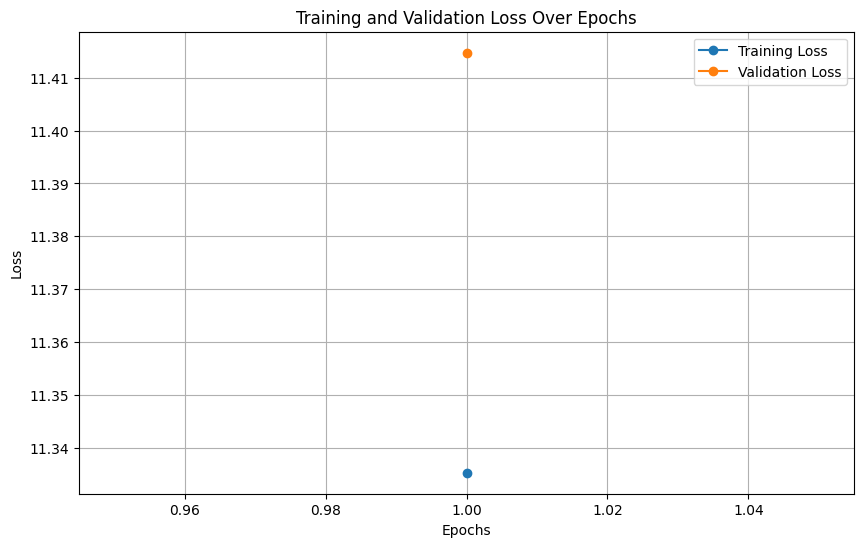

Final Translation: 我已经展示了这两张幻灯片来证明,北极冰盖在过去的3百万年中大部分时间都是低级州的大小,但现在已经减少了40%。


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
import spacy
from datasets import load_dataset
from transformers import MBartForConditionalGeneration, MBart50Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, AdamW, EarlyStoppingCallback
import re
import torch
import warnings
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入 SpaCy NER 模型
nlp = spacy.load("en_core_web_sm")

# 載入 IWSLT 2017 英中翻譯資料集
dataset = load_dataset('iwslt2017', 'iwslt2017-en-zh', split='train[:20000]', trust_remote_code=True)

# 載入 mBART 模型和 Tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

# 設定源語言和目標語言
tokenizer.src_lang = "en_XX"  # 英文
tokenizer.tgt_lang = "zh_CN"  # 簡體中文

# 實體識別和標記的函數
def mark_entities(text):
    doc = nlp(text)
    modified_text = text
    entities = []
    for ent in doc.ents:
        entity_marker = f"<<{ent.label_}:{ent.text}>>"
        modified_text = modified_text.replace(ent.text, entity_marker)
        entities.append((ent.text, ent.label_))
    return modified_text, entities

# 預處理函數
def preprocess_function(examples):
    inputs = []
    targets = []
    entities_list = []
    for ex in examples["translation"]:
        marked_text, entities = mark_entities(ex["en"])
        target = ex["zh"]
        inputs.append(marked_text)
        targets.append(target)
        entities_list.append(entities)
    
    # Tokenize 輸入和標籤
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["entities"] = entities_list
    return model_inputs

# 對數據集進行 Tokenize 和實體標記
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 訓練參數設置
training_args = Seq2SeqTrainingArguments(
    output_dir="./mbart_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

# 將數據集劃分為訓練集和驗證集
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# 自定義 Layer-wise Learning Rate Decay
layer_decay = 0.8
optimizer_grouped_parameters = []
num_layers = len(model.model.encoder.layers)

for i, layer in enumerate(model.model.encoder.layers):
    lr = training_args.learning_rate * (layer_decay ** (num_layers - i - 1))
    optimizer_grouped_parameters.append({"params": layer.parameters(), "lr": lr})
optimizer_grouped_parameters.append({"params": model.model.shared.parameters(), "lr": training_args.learning_rate})

# 初始化 optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=training_args.learning_rate)

# 自定義 Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# 開始訓練
trainer.train()

# 提取並記錄訓練和驗證損失
training_losses = []
validation_losses = []

for log in trainer.state.log_history:
    if 'loss' in log:
        training_losses.append(log['loss'])
    if 'eval_loss' in log:
        validation_losses.append(log['eval_loss'])

# 確保訓練和驗證損失的長度一致
min_length = min(len(training_losses), len(validation_losses))
training_losses = training_losses[:min_length]
validation_losses = validation_losses[:min_length]

# 繪製損失曲線
epochs = range(1, min_length + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label="Training Loss", marker="o")
plt.plot(epochs, validation_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 後處理實體標記
def postprocess_translation(translated_text, entities):
    for ent_text, ent_label in entities:
        entity_marker_pattern = re.escape(f"<<{ent_label}:") + r"(.*?)>>"
        translated_text = re.sub(entity_marker_pattern, ent_text, translated_text, count=1)
    
    translated_text = re.sub(r"\b(DATE|LOC|PERCENT|CARDINAL):", "", translated_text)
    translated_text = re.sub(r"\(.*?\)", "", translated_text)  # 避免多餘標記出現
    return translated_text

# 使用訓練好的模型進行翻譯並還原實體
def entity_aware_translate(input_text):
    marked_text, entities = mark_entities(input_text)
    inputs = tokenizer(marked_text, return_tensors="pt").to(device)
    translated_tokens = model.generate(
        inputs["input_ids"],
        max_length=256,
        forced_bos_token_id=tokenizer.lang_code_to_id["zh_CN"]
    )
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    final_translation = postprocess_translation(translated_text, entities)
    return final_translation

# 測試翻譯
input_text = "Last year I showed these two slides so that demonstrate that the arctic ice cap, which for most of the last three million years has been the size of the lower 48 states, has shrunk by 40 percent."
final_translation = entity_aware_translate(input_text)
print("Final Translation:", final_translation)

# 保存模型和 Tokenizer
trainer.save_model("./mbart_finetuned")
tokenizer.save_pretrained("./mbart_finetuned")

# 驗證階段設置
val_dataset = load_dataset('iwslt2017', 'iwslt2017-en-zh', split='validation', trust_remote_code=True)
meteor_metric = evaluate.load("meteor")
bleu_metric = evaluate.load("bleu")

# 驗證函數
def evaluate_model(val_dataset):
    val_predictions = []
    val_references = []
    for example in tqdm(val_dataset, desc="Processing Validation Set"):
        input_text = example["translation"]["en"]
        reference_text = example["translation"]["zh"]
        
        # 顯示原本的英文句子
        print("Original English Text:", input_text)
        
        final_translation = entity_aware_translate(input_text)
        print("Reference Text:", reference_text)
        print("Translated Text:", final_translation)
        print("=" * 50)
        
        val_predictions.append(final_translation)
        val_references.append([reference_text])
    
    # 計算 METEOR 和 BLEU 分數
    val_meteor_score = meteor_metric.compute(predictions=val_predictions, references=val_references)
    val_bleu_score = bleu_metric.compute(predictions=val_predictions, references=val_references)
    print("Validation Set METEOR score:", val_meteor_score)
    print("Validation Set BLEU score:", val_bleu_score)

# 執行驗證
evaluate_model(val_dataset)